In [1]:
import tensorflow as tf
import numpy as np
import sys
from datetime import datetime
from functools import partial
from utils import *

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

MODEL_PATH = "models/autoencoder/"

In [12]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

In [3]:
input_img = Input(shape=(28, 28, 1))                                    # 28 x 28 x 1

x = Conv2D(8, (3, 3), activation='relu', padding='same')(input_img)    # 28 x 28 x 8
x_M1 = MaxPooling2D((2, 2), padding='same')(x)                          # 14 x 14 x 8
x_C2 = Conv2D(4, (3, 3), activation='relu', padding='same')(x_M1)       # 14 x 14 x 4
encoded = MaxPooling2D((2, 2), padding='same')(x_C2)                    # 7 x 7 x 4 = (28 x 28 x 1) * 0.25 (and each feature map has the same replicated weights so it decreases again the complexity)

x_C3 = Conv2D(4, (3, 3), activation='relu', padding='same')(encoded)    # 7 x 7 x 4
x_U1 = UpSampling2D((2, 2))(x_C3)                                       # 14 x 14 x 4
x_C4 = Conv2D(8, (3, 3), activation='relu', padding='same')(x_U1)      # 14 x 14 x 8
x_U2 = UpSampling2D((2, 2))(x_C4)                                       # 28 x 28 x 8
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x_U2) # 28 x 28 x 1

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [4]:
x.shape

TensorShape([Dimension(None), Dimension(28), Dimension(28), Dimension(8)])

In [5]:
x_M1.shape

TensorShape([Dimension(None), Dimension(14), Dimension(14), Dimension(8)])

In [6]:
x_C2.shape

TensorShape([Dimension(None), Dimension(14), Dimension(14), Dimension(4)])

In [7]:
encoded.shape

TensorShape([Dimension(None), Dimension(7), Dimension(7), Dimension(4)])

In [8]:
x_C3.shape

TensorShape([Dimension(None), Dimension(7), Dimension(7), Dimension(4)])

In [9]:
x_U1.shape

TensorShape([Dimension(None), Dimension(14), Dimension(14), Dimension(4)])

In [10]:
x_C4.shape

TensorShape([Dimension(None), Dimension(14), Dimension(14), Dimension(8)])

In [11]:
x_U2.shape

TensorShape([Dimension(None), Dimension(28), Dimension(28), Dimension(8)])

In [12]:
decoded.shape

TensorShape([Dimension(None), Dimension(28), Dimension(28), Dimension(1)])

In [17]:
from tensorflow.keras.datasets import mnist
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

In [4]:
autoencoder = tf.keras.models.load_model(MODEL_PATH + 'autoencoder.h5')

In [5]:
from tensorflow.keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=100,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 52s 870us/sample - loss: 0.1290 - val_loss: 0.1278
Epoch 2/100
60000/60000 [==============================] - 62s 1ms/sample - loss: 0.1289 - val_loss: 0.1277
Epoch 3/100
60000/60000 [==============================] - 71s 1ms/sample - loss: 0.1288 - val_loss: 0.1277
Epoch 4/100
60000/60000 [==============================] - 71s 1ms/sample - loss: 0.1288 - val_loss: 0.1276
Epoch 5/100
60000/60000 [==============================] - 71s 1ms/sample - loss: 0.1287 - val_loss: 0.1275
Epoch 6/100
60000/60000 [==============================] - 71s 1ms/sample - loss: 0.1287 - val_loss: 0.1275
Epoch 7/100
60000/60000 [==============================] - 71s 1ms/sample - loss: 0.1286 - val_loss: 0.1274
Epoch 8/100
60000/60000 [==============================] - 71s 1ms/sample - loss: 0.1285 - val_loss: 0.1274
Epoch 9/100
60000/60000 [==============================] - 71s 1ms/sample - loss: 0.

In [6]:
# saving model
autoencoder.save(MODEL_PATH + 'autoencoder.h5')

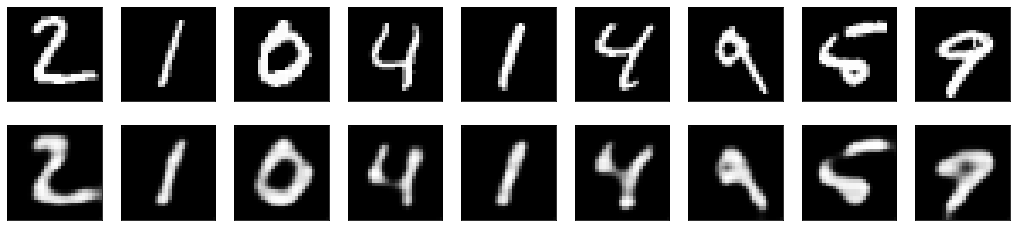

In [7]:
decoded_imgs = autoencoder.predict(x_test[:10])

n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Restore model used for unsupervised pre-training

In [8]:
pretrained_autoencoder = tf.keras.models.load_model(MODEL_PATH + 'autoencoder.h5')
pretrained_autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 8)         80        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 4)         292       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 4)           0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 7, 7, 4)           148       
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 14, 14, 4)         0   

### adding layers at the end of the pretrained model

In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

In [13]:
#removing decoder (last 4 layers)
x = pretrained_autoencoder.layers[-5].output
# Adding layers
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), strides=2, activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), strides=2, activation='relu', padding='same')(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
# Adding a fully connected layer for the 10 classes 0 to 9
predictions = Dense(10, activation='softmax')(x)

In [14]:
model = Model(inputs=pretrained_autoencoder.input, outputs=predictions)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 8)         80        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 4)         292       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 4)           0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 7, 7, 4)           148       
_________________________________________________________________
conv2d (Conv2D)              (None, 7, 7, 32)          1184  

### freezing model

In [15]:
# freeze all layers of the pre-trained model
# we will only update the weights for the added layers
for layer in pretrained_autoencoder.layers:
    layer.trainable = False

# compile the model with adam optimizer and sparse_categorical_crossentropy loss function
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

### Training without data augmentation

In [18]:
samples_for_training = 500
X_train, y_train = x_train[:samples_for_training], y_train[:samples_for_training]

In [27]:
history = model.fit(X_train, y_train, batch_size=100, epochs=10, verbose=1)

Epoch 1/10
1000/1000 [==============================] - 0s 241us/sample - loss: 0.0076 - sparse_categorical_accuracy: 0.9990
Epoch 2/10
1000/1000 [==============================] - 0s 244us/sample - loss: 0.0066 - sparse_categorical_accuracy: 1.0000
Epoch 3/10
1000/1000 [==============================] - 0s 238us/sample - loss: 0.0055 - sparse_categorical_accuracy: 1.0000
Epoch 4/10
1000/1000 [==============================] - 0s 214us/sample - loss: 0.0061 - sparse_categorical_accuracy: 1.0000
Epoch 5/10
1000/1000 [==============================] - 0s 216us/sample - loss: 0.0054 - sparse_categorical_accuracy: 0.9990
Epoch 6/10
1000/1000 [==============================] - 0s 211us/sample - loss: 0.0071 - sparse_categorical_accuracy: 0.9990
Epoch 7/10
1000/1000 [==============================] - 0s 231us/sample - loss: 0.0053 - sparse_categorical_accuracy: 1.0000
Epoch 8/10
1000/1000 [==============================] - 0s 214us/sample - loss: 0.0043 - sparse_categorical_accuracy: 1.0000


In [28]:
score = model.evaluate(x_test,y_test, verbose=1)

10000/10000 [==============================] - 2s 192us/sample - loss: 0.4192 - sparse_categorical_accuracy: 0.9019


## Neural net without pre-trained model

In [38]:
#removing decoder (last 4 layers)
input_images = Input(shape=(28, 28, 1)) 
# Adding layers
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_images)
x = Conv2D(64, (3, 3), strides=2, activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), strides=2, activation='relu', padding='same')(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
# Adding a fully connected layer for the 10 classes 0 to 9
model_without_pretrained = Dense(10, activation='softmax')(x)

In [39]:
model_basic = Model(inputs=input_images, outputs=model_without_pretrained)
model_basic.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 7, 7, 128)         73856     
_________________________________________________________________
flatten_4 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               802944    
_________________________________________________________________
dense_9 (Dense)              (None, 10)                1290

In [42]:
# compile the model with adam optimizer and sparse_categorical_crossentropy loss function
model_basic.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

In [44]:
history = model_basic.fit(X_train, y_train, batch_size=100, epochs=10, verbose=1)

Epoch 1/10
1000/1000 [==============================] - 1s 992us/sample - loss: 0.0113 - sparse_categorical_accuracy: 0.9980
Epoch 2/10
1000/1000 [==============================] - 1s 1ms/sample - loss: 0.0048 - sparse_categorical_accuracy: 1.0000
Epoch 3/10
1000/1000 [==============================] - 1s 1ms/sample - loss: 0.0021 - sparse_categorical_accuracy: 1.0000
Epoch 4/10
1000/1000 [==============================] - 1s 1ms/sample - loss: 0.0012 - sparse_categorical_accuracy: 1.0000
Epoch 5/10
1000/1000 [==============================] - 1s 1ms/sample - loss: 7.2854e-04 - sparse_categorical_accuracy: 1.0000
Epoch 6/10
1000/1000 [==============================] - 1s 1ms/sample - loss: 5.8663e-04 - sparse_categorical_accuracy: 1.0000
Epoch 7/10
1000/1000 [==============================] - 1s 1ms/sample - loss: 4.5476e-04 - sparse_categorical_accuracy: 1.0000
Epoch 8/10
1000/1000 [==============================] - 1s 1ms/sample - loss: 3.7774e-04 - sparse_categorical_accuracy: 1.000

In [ ]:
score = model_basic.evaluate(x_test,y_test, verbose=1)